<a href="https://colab.research.google.com/github/Krotonus/Multimodal-Workshop/blob/main/maze_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPTWorld Golf

The goal of this exercise is to write a prompt that can solve the movement of an AI in a grid world using prompting. You need to avoid walls, pick up a key, and then reach the goal.

You will need to use use OpenAI Key to run the exercise. You can get it here:

https://platform.openai.com/account/api-keys

In [ ]:
from google.colab import userdata
ai_key = userdata.get('GOOGLE_API_KEY')

MODEL_NAME = "gemini-2.0-flash"

In [ ]:
#@title Install (collapse me)
%%capture
!sudo apt-get install libcairo2-dev
!pip install -U git+https://github.com/chalk-diagrams/chalk openai pycairo tiktoken

This cell can be ignored. It just imports the necessary libraries and sets up a prompt call.


In [ ]:
#@title Import (collapse me)
from dataclasses import dataclass
from chalk import *
from colour import Color
import inspect
import os
import openai
from typing import List, Tuple, Optional
from enum import Enum
import io
from IPython.display import Image
from contextlib import redirect_stdout
import imageio
import tiktoken
tab = "    "

client = openai.OpenAI(api_key=ai_key, base_url='https://generativelanguage.googleapis.com/v1beta/openai/')

def start(prompt):
    out = ""
    for chunk in client.chat.completions.create(
        model= MODEL_NAME,
        messages=[{
            "role": "user",
            "content": prompt,

        }],
        stream=True,
        temperature= 0
    ):
        content = chunk.choices[0].delta.content
        if content is not None:
            out += content
            print(content, end="")
            yield out
    yield out

def num_tokens_from_string(string: str, encoding_name: str="gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Game Code

This code creates a mini-game to play. It takes place on a hexagon. You are represented by a circle. You need to first pick up a key represented by a triangle. You finally need to make it to the cross to finish the game. The actions show each of the directions you can move.



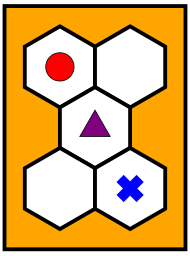

In [ ]:
#@title Game Code

# Possible Actions
class Actions(Enum):
    UPRIGHT = "UR"
    RIGHT = "R"
    DOWNRIGHT = "DR"
    DOWNLEFT = "DL"
    LEFT = "L"
    UPLEFT = "UL"
    PICKUP = "Pickup"

# Movements
change = {
    Actions.UPRIGHT : (-1, 1),
    Actions.RIGHT : (0, 2),
    Actions.DOWNRIGHT : (1, 1),
    Actions.DOWNLEFT : (1, -1),
    Actions.LEFT : (0, -2),
    Actions.UPLEFT : (-1, -1),
    Actions.PICKUP : (0, 0),
}
change_str = {action.value: change[action] for action in Actions}
def add(a, b):
    return a[0] + b[0], a[1] + b[1]

@dataclass
class Board:
    grid: List[str]
    player_pos: Tuple[int, int]
    flag_pos: Tuple[int, int]
    wall_pos:List[Tuple[int, int]]
    key_pos:Optional[Tuple[int, int]]

    def move(self, action: Actions) -> 'Board':
        "Move by creating a new board."
        d_m = change[action]
        if action == Actions.PICKUP:
            if self.player_pos == self.key_pos:
                return Board(self.grid, self.player_pos, self.flag_pos, self.wall_pos, None)
            else:
                return self

        new_player_pos = add(self.player_pos, d_m)
        # Out of bounds
        if new_player_pos[0] < 0 or new_player_pos[0] >= len(self.grid):
            return self
        if new_player_pos[1] < 0 or new_player_pos[1] >= len(self.grid[0]):
            return self
        # Can't move through walls
        if self.grid[new_player_pos[0]][new_player_pos[1]] == 'W':
            return self

        new_grid = [row[:] for row in self.grid] # Create a copy of the grid
        new_grid[self.player_pos[0]][self.player_pos[1]] = '.'
        new_grid[new_player_pos[0]][new_player_pos[1]] = '@'
        return Board(new_grid, new_player_pos, self.flag_pos, self.wall_pos, self.key_pos)

    def __str__(self) -> str:
        return '\n'.join(''.join(row) for i, row in enumerate(self.grid))

    @classmethod
    def create_empty_board(cls, size: Tuple[int, int], key_pos, flag_pos, init, wall_pos) -> 'Board':
        grid = [['.' if i % 2 == j % 2  else " " for i in range(size[1])] for j in range(size[0])]
        player_pos = init
        flag_pos = flag_pos
        grid[player_pos[0]][player_pos[1]] = '@'
        grid[flag_pos[0]][flag_pos[1]] = 'P'
        grid[key_pos[0]][key_pos[1]] = 'K'
        for pos in wall_pos:
            grid[pos[0]][pos[1]] = 'W'
        return cls(grid, player_pos, flag_pos, wall_pos, key_pos)

class Game:
    def __init__(self, init, flag, walls, key, boundary):
        "Create the version of the game that the AI sees."
        self.boundary = boundary
        self.board = Board.create_empty_board(boundary, key, flag, init, walls)
        self.original = self.board
        self.actions = []

    def move(self, action):
        self.board = self.board.move(action)
        self.actions.append(action)

    @property
    def walls(self):
        return self.board.wall_pos

    def __repr__(self) -> str:
        walls = ",".join(map(str, self.board.wall_pos))
        return f"Game(init={self.board.player_pos}, flag={self.board.flag_pos}, walls= {self.board.wall_pos}, boundary= {self.boundary}, key= {self.board.key_pos})"

# This is the version of move that the AI can see.
def move(game, action, old_pos):
    # ACTIONS (must be legal)
    game.move(Actions(action))
    offset = change_str[action]
    pos = (old_pos[0] + offset[0], old_pos[1] + offset[1])
    assert 0 <= pos[0] < game.boundary[0]
    assert 0 <= pos[1] < game.boundary[1]
    assert pos not in game.walls
    if action == "PU":
        assert pos == game.key
    return pos

We can look at the board by drawing it.

In [ ]:
#@title Drawing code
def draw_board(grid, num=0):
    hex = regular_polygon(6, 1).rotate_by(1/12).line_width(0.5).fill_color(Color("white"))
    w = hex.get_envelope().width
    canvas = empty()
    for r, b in enumerate(grid):
        def show(v):
            if v == ".":
                return hex
            if v == "@":
                return hex + circle(0.35).fill_color(Color("red"))
            if v == "P":
                x = rectangle(0.25, 0.7).fill_color(Color("blue")).line_width(0)
                return hex + (x.rotate_by(0.25/2) + x.rotate_by(-0.25/2))
            if v == "K":
                return hex + triangle(0.75).fill_color(Color("purple"))
            if v == "W":
                return hex.fill_color(Color("black"))
            if v ==" ":
                return hex
        row = hcat(show(v) for i, v in enumerate(b[1 if r %2 else 0::2]))
        canvas += row.translate(w * 0.5 if r%2 else 0, 1.5 * r)
    canvas = canvas.center_xy().frame(0.5)
    canvas = rectangle(canvas.get_envelope().width, canvas.get_envelope().height).line_width(0.5).fill_color(Color("orange")) + canvas
    canvas.render(f"pic{num}.png", 256)
    return canvas



In [ ]:
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2)])
display(draw_board(game.board.grid))
move(game, "DR", (0,0))
display(draw_board(game.board.grid))

## Prompt Code

The puzzle is to write prompt code to make the model accomplish this task. We have provided some scaffolding code for you. The code creates:

* A header for describing the game.
* A function `make_fun` that shows the AI how to move in code.
* A footer to describe the final game board that you want the mode to solve.

You can fill this in a watch how the model moves around.

In [ ]:
#@title Make the Prompt
def make_fun(board, actions):
    "This function generates python code for few-shot examples"
    out = tab + "p = " + str(board.player_pos)
    for i, action in enumerate(actions):
        new_board = board.move(action)
        out += f"""
        # print(new_board) <- uncomment if you want to see the movement.
    # TODO ADD CODE
    p = move(b, "{action.value}", p) # TODO ADD CODE"""
        board = new_board
    return out

ex = 0
def prompt(game):
    """
    You should fill these sections out to teach the AI how to play the game.

    Or you may do your own thing :)
    """
    print(f"""
# TODO: DESCRIBE THE GAME

# TODO: DESCRIBE THE ACTIONS
change_str = {change_str}

{inspect.getsource(move)}
""")

    def example(game, actions):
        """
        This code makes a few shot example. You don't need to edit it.
        """
        global ex
        ex += 1
        print(f"""
#-------------
# EXAMPLE:
def example{ex}():
    b = {repr(game)}
{make_fun(game.board, actions)}
    return b
# ------------
""")

    # Create a few shot example (you may not need this)
    board = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[(2, 0)])
    actions = [Actions.DOWNRIGHT, Actions.PICKUP, Actions.DOWNRIGHT]
    example(board, actions)

    # Test case
    print(f"""
# ----
# TODO: ADD any custom example code
#---
# TODO: FINAL description.

# Contraints for this function:", {repr(game)}
# Please fill this in with code like the examples above (do not provide a description):
#
# The following function `my_example` instantiates a GameBoard called b with these constraints.

""")


This code lets you make a game and see the output for a prompt for that game. There are easy, medium, and hard games.

In [ ]:
# Easy
game = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])

# Medium
# game = Game(boundary=(5, 5), key=(3, 1), flag=(4, 4), init=(0, 0), walls=[(1, 1)])

# Hard (This is the main one)
#game = Game(boundary=(8, 15), key=(3, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (1, 1), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

# Evil
#game = Game(boundary=(8, 15), key=(5, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (3, 3), (4, 2), (1, 1), (2, 4), (7, 11), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

display(draw_board(game.board.grid))

f = io.StringIO()
with redirect_stdout(f):
    ex = 0
    prompt(game)
my_prompt = f.getvalue()
print(my_prompt)

In [ ]:
# Run an LLM and execute it as it runs.
q = {}
i = 0
for prefix in start(my_prompt):
    ps = prefix.split("\n")
    if len(ps) > 3 and not ps[-2].strip().startswith("#") and prefix.endswith("\n"):
        exec(prefix + "\n    return b\nq['board'] = my_example()")
        display(draw_board(q["board"].board.grid, i))
        i += 1

# Animate the outputs as a GIF
def animate(i):
    images = []
    for i in range(i):
        images.append(imageio.v2.imread(f"pic{i}.png"))
    return imageio.v2.mimsave('movie.gif', images, **{ 'duration': 0.5 })
animate(i)
display(Image("movie.gif"))


# Print the number of tokens used
print("Input Tokens:", num_tokens_from_string(my_prompt))
print("Output Tokens:", num_tokens_from_string(prefix))